In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext line_profiler

In [82]:
from functools import partial

import time
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [3]:
import jax
import jax.numpy as jnp

import diffrax
import equinox as eqx
import optax

from haiku import PRNGSequence

In [4]:
import exciting_environments as excenvs
from models import NeuralEulerODE

### Dummy Example for non-linear vector field:
- learn vector field with an ODE-solver that is more complex than simple Euler
  

In [12]:
# setup PRNG
key = jax.random.PRNGKey(seed=21)

data_key, model_key, key = jax.random.split(key, 3)
data_rng = PRNGSequence(data_key)

### Data generation:

In [137]:
def _get_data(ts, *, key):

    def f(t, y, args):
        """Vmap-able Volterra-Lotka ODE.
        
        Args:
            t: current time (just for API, ODE is time-invariant)
            y: current observation
    
        Returns:
            The observation's derivative w.r.t. time for the given input observation
        """
        alpha = 0.1  # Reproduction rate of prey
        beta = 0.02  # Predation rate
        delta = 0.01  # Reproduction rate of predator
        gamma = 0.1  # Death rate of predator

        dydt = jnp.array([
            alpha * y[0] - beta * y[0] * y[1],
            delta * y[0] * y[1] - gamma * y[1]
        ])
        return dydt

    y0 = jax.random.uniform(key, (2,), minval=1, maxval=3)

    solver = diffrax.Tsit5()
    dt0 = 1
    saveat = diffrax.SaveAt(ts=ts)
    sol = diffrax.diffeqsolve(
        diffrax.ODETerm(f), solver, ts[0], ts[-1], dt0, y0, saveat=saveat
    )
    ys = sol.ys
    return ys

@partial(jax.jit, static_argnums=(0))
def get_data(dataset_size, *, key):
    ts = jnp.linspace(0, 100, 1000)
    key = jax.random.split(key, dataset_size)
    ys = jax.vmap(lambda key: _get_data(ts, key=key))(key)
    return ts, ys

Computation time: 1.3164241313934326


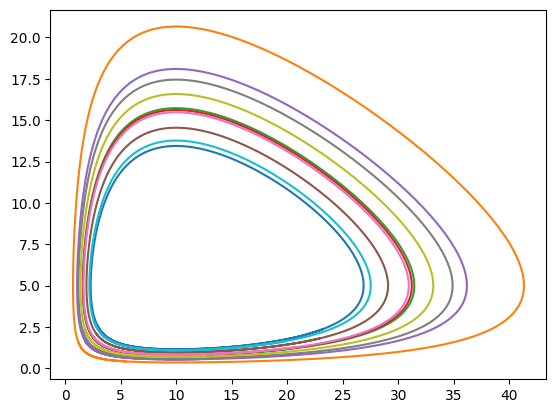

In [138]:
start = time.time()
ts, ys = get_data(256, key=next(data_rng))
end = time.time()

print(f"Computation time: {end - start}")

for i in range(10):
    plt.plot(ys[i, :, 0], ys[i, :, 1])
    plt.grid()

### Define model:

In [142]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.mlp = eqx.nn.MLP(
            in_size=data_size,
            out_size=data_size,
            width_size=width_size,
            depth=depth,
            activation=jax.nn.softplus,
            key=key,
        )

    def __call__(self, t, y, args):
        return self.mlp(y)

class NeuralODE(eqx.Module):
    func: Func

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.func = Func(data_size, width_size, depth, key=key)

    def __call__(self, ts, y0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys

### Train model:

In [187]:
@eqx.filter_value_and_grad
def grad_loss(model, ti, yi):
    
    y_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:, 0, :])
    return jnp.mean((yi - y_pred) ** 2)

@eqx.filter_jit
def make_step(ti, yi, model, opt_state):
    loss, grads = grad_loss(model, ti, yi)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [256]:
def evaluation_plot():
    ts, ys = get_data(batch_size, key=next(data_rng))
    
    plt.plot(ts, ys[0, :, 0], c="dodgerblue", label="Real" )
    plt.plot(ts, ys[0, :, 1], c="dodgerblue")
    model_y = model(ts, ys[0, 0])
    plt.plot(ts, model_y[:, 0], c="crimson", label="Model")
    plt.plot(ts, model_y[:, 1], c="crimson")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.xlabel(r"$t$ in $s$")
    plt.ylabel(r"$x(k)$ / $\hat{x}(k)$")
    plt.savefig("lv_timeseries_plot.svg")
    plt.show()
    
    plt.plot(ys[0, :, 0], ys[0, :, 1], c="dodgerblue", label="Real")
    plt.plot(model_y[:, 0], model_y[:, 1], c="crimson", label="Model")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.xlabel(r"$x_0$")
    plt.ylabel(r"$x_1$")
    plt.savefig("lv_statespace_plot.svg")
    plt.show()

  0%|          | 0/20000 [00:00<?, ?it/s]

Episode: 0, Loss: 0.6477282047271729, Computation time: 8.810433626174927


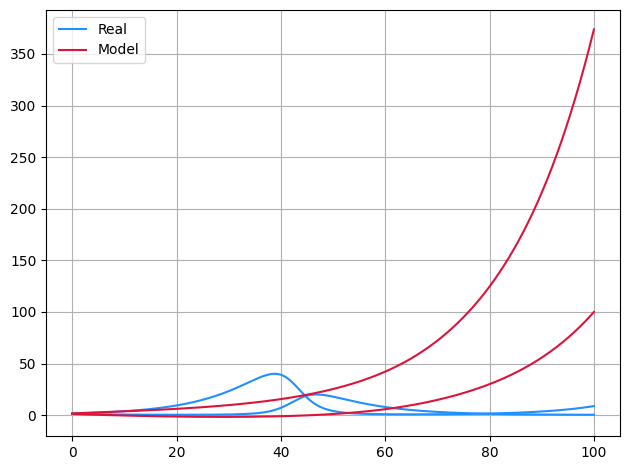

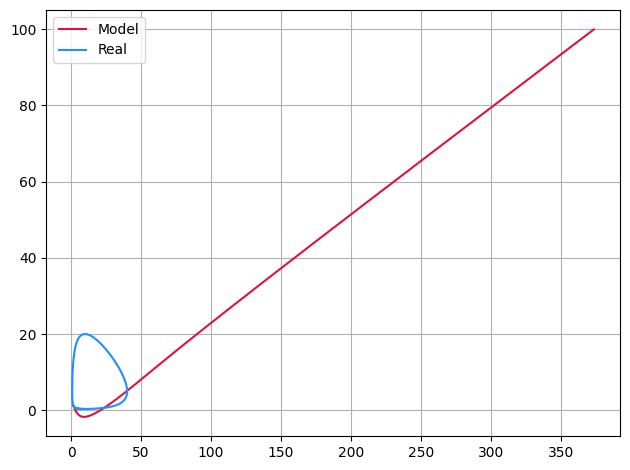

Episode: 10, Loss: 0.152192622423172, Computation time: 0.055741310119628906
Episode: 20, Loss: 0.0334133580327034, Computation time: 0.04243612289428711
Episode: 30, Loss: 0.020452503114938736, Computation time: 0.0469050407409668
Episode: 40, Loss: 0.013568935915827751, Computation time: 0.05796670913696289
Episode: 50, Loss: 0.004815323743969202, Computation time: 0.04089760780334473
Episode: 60, Loss: 0.0021926856134086847, Computation time: 0.04586195945739746
Episode: 70, Loss: 0.0012873938539996743, Computation time: 0.054316043853759766
Episode: 80, Loss: 0.0014228253858163953, Computation time: 0.045166730880737305
Episode: 90, Loss: 0.0013080169446766376, Computation time: 0.04701399803161621
Episode: 100, Loss: 0.001478416845202446, Computation time: 0.05552816390991211
Episode: 110, Loss: 0.0010994698386639357, Computation time: 0.03137493133544922
Episode: 120, Loss: 0.0014657474821433425, Computation time: 0.04692888259887695
Episode: 130, Loss: 0.0011740121990442276, Com

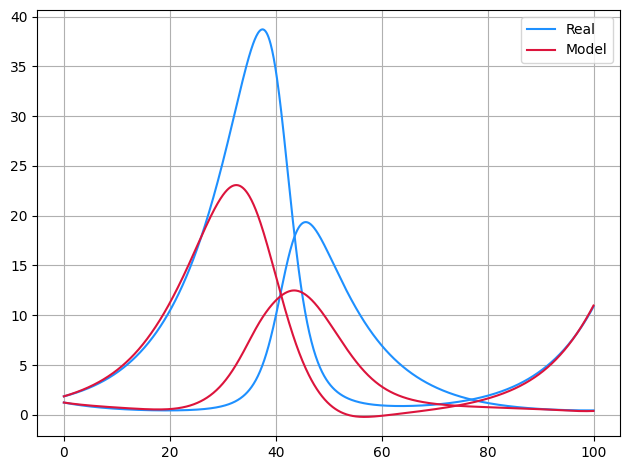

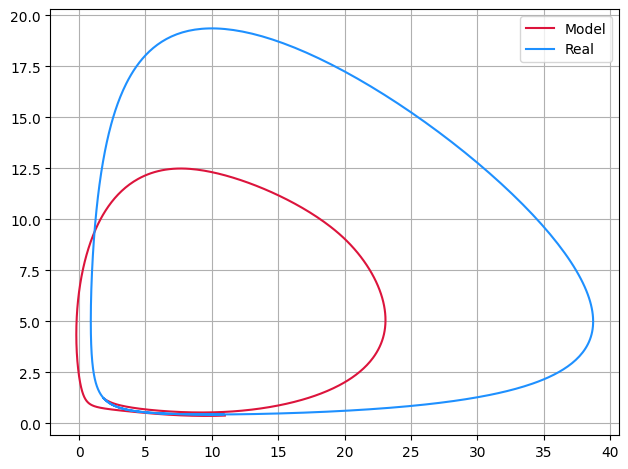

Episode: 4010, Loss: 8.45530891418457, Computation time: 0.1499800682067871
Episode: 4020, Loss: 11.828330993652344, Computation time: 0.1494598388671875
Episode: 4030, Loss: 7.17168664932251, Computation time: 0.15341567993164062
Episode: 4040, Loss: 4.221395015716553, Computation time: 0.13142013549804688
Episode: 4050, Loss: 3.042311191558838, Computation time: 0.15357732772827148
Episode: 4060, Loss: 3.269545078277588, Computation time: 0.14226770401000977
Episode: 4070, Loss: 2.9658164978027344, Computation time: 0.14435553550720215
Episode: 4080, Loss: 2.323247194290161, Computation time: 0.14348864555358887
Episode: 4090, Loss: 2.1377298831939697, Computation time: 0.16391754150390625
Episode: 4100, Loss: 2.2318003177642822, Computation time: 0.14430642127990723
Episode: 4110, Loss: 1.927248239517212, Computation time: 0.14722084999084473
Episode: 4120, Loss: 1.6229887008666992, Computation time: 0.14758634567260742
Episode: 4130, Loss: 1.5173434019088745, Computation time: 0.16

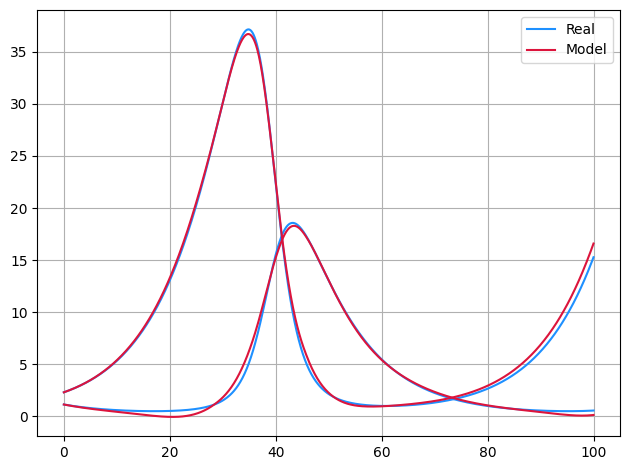

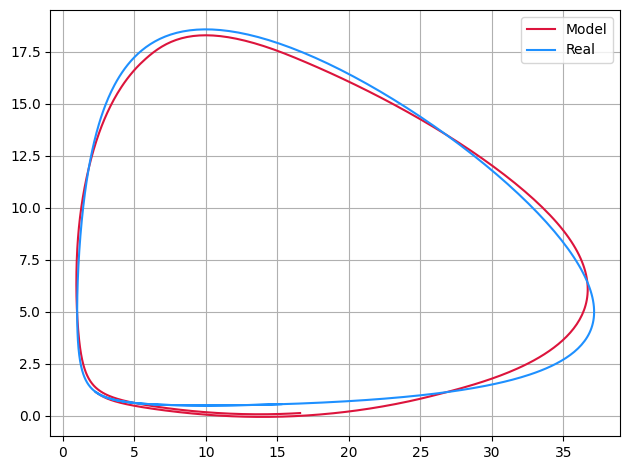

Episode: 8010, Loss: 0.18522143363952637, Computation time: 0.23455142974853516
Episode: 8020, Loss: 0.19493864476680756, Computation time: 0.21824336051940918
Episode: 8030, Loss: 5.283908367156982, Computation time: 0.24042248725891113
Episode: 8040, Loss: 4.930043697357178, Computation time: 0.256549596786499
Episode: 8050, Loss: 1.9689993858337402, Computation time: 0.26688361167907715
Episode: 8060, Loss: 1.0786443948745728, Computation time: 0.2541379928588867
Episode: 8070, Loss: 0.7917380332946777, Computation time: 0.25295567512512207
Episode: 8080, Loss: 0.6300983428955078, Computation time: 0.37381672859191895
Episode: 8090, Loss: 0.4761291742324829, Computation time: 0.3385889530181885
Episode: 8100, Loss: 0.44282299280166626, Computation time: 0.29474735260009766
Episode: 8110, Loss: 0.3374202251434326, Computation time: 0.26619434356689453
Episode: 8120, Loss: 0.3594707250595093, Computation time: 0.279163122177124
Episode: 8130, Loss: 0.34459933638572693, Computation tim

KeyboardInterrupt: 

In [221]:
lr = 1e-3
n_episodes = 20_000
batch_size = 128

model = NeuralODE(data_size=2, width_size=64, depth=2, key=model_key)

optim = optax.adabelief(lr)
opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

horizon = 0

for episode in tqdm(range(n_episodes)):

    start = time.time()
    ts, ys = get_data(batch_size, key=next(data_rng))


    if (episode % 1000)== 0 and horizon < ys.shape[1]:
         horizon += 100

    ts = ts[:horizon]
    ys = ys[:, :horizon, :]   

    loss, model, opt_state = make_step(ts, ys, model, opt_state)
    end = time.time()

    if (episode % 10) == 0 or episode == n_episodes - 1:
        print(f"Episode: {episode}, Loss: {loss}, Computation time: {end - start}")

    if (episode % 4000) == 0 or episode == n_episodes - 1:
        evaluation_plot()

  0%|          | 0/20000 [00:00<?, ?it/s]

Episode: 0, Loss: 0.16688477993011475, Computation time: 0.23882412910461426


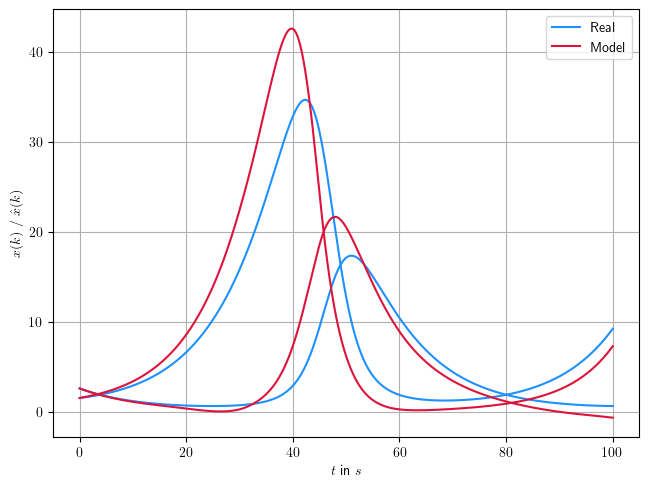

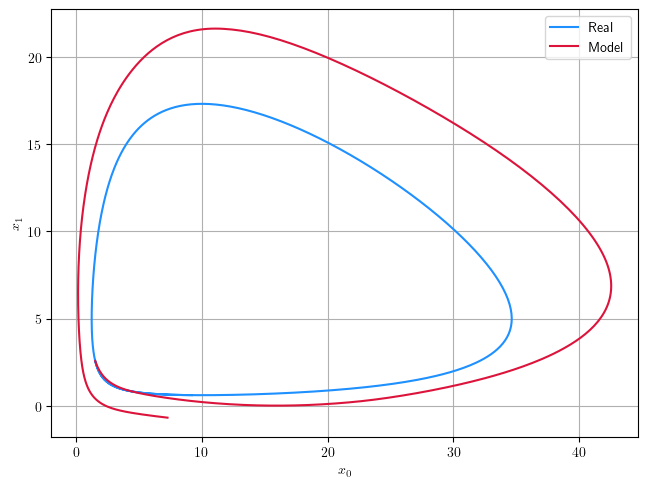

Episode: 10, Loss: 3.76674222946167, Computation time: 0.22110939025878906
Episode: 20, Loss: 0.43585020303726196, Computation time: 0.22301983833312988
Episode: 30, Loss: 0.5798450112342834, Computation time: 0.20970773696899414
Episode: 40, Loss: 0.34289392828941345, Computation time: 0.23372220993041992
Episode: 50, Loss: 0.2194099873304367, Computation time: 0.22781062126159668
Episode: 60, Loss: 0.18399198353290558, Computation time: 0.22734379768371582
Episode: 70, Loss: 0.12852834165096283, Computation time: 0.217498779296875
Episode: 80, Loss: 0.15462294220924377, Computation time: 0.21802139282226562
Episode: 90, Loss: 0.11572884023189545, Computation time: 0.21730399131774902
Episode: 100, Loss: 0.14103855192661285, Computation time: 0.23118138313293457
Episode: 110, Loss: 0.17904867231845856, Computation time: 0.24154901504516602
Episode: 120, Loss: 0.11378101259469986, Computation time: 0.23696279525756836
Episode: 130, Loss: 0.12016753107309341, Computation time: 0.2444393

KeyboardInterrupt: 

In [254]:
lr = 1e-4
optim = optax.adabelief(lr)
opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

for episode in tqdm(range(n_episodes)):

    start = time.time()
    ts, ys = get_data(batch_size, key=next(data_rng))

    loss, model, opt_state = make_step(ts, ys, model, opt_state)
    end = time.time()

    if (episode % 10) == 0 or episode == n_episodes - 1:
        print(f"Episode: {episode}, Loss: {loss}, Computation time: {end - start}")

    if (episode % 4000) == 0 or episode == n_episodes - 1:
        evaluation_plot()

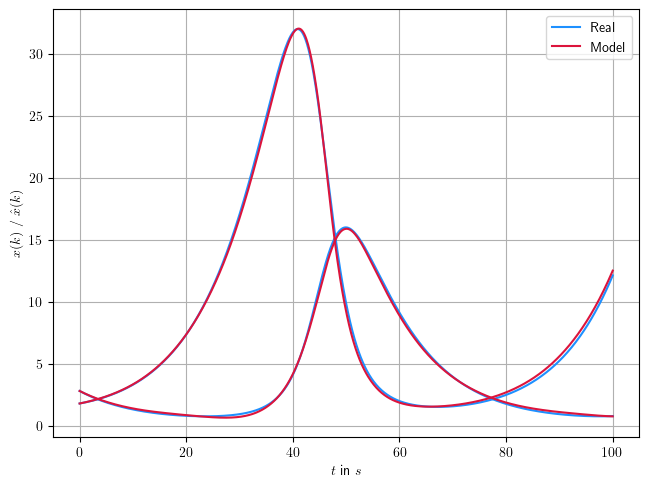

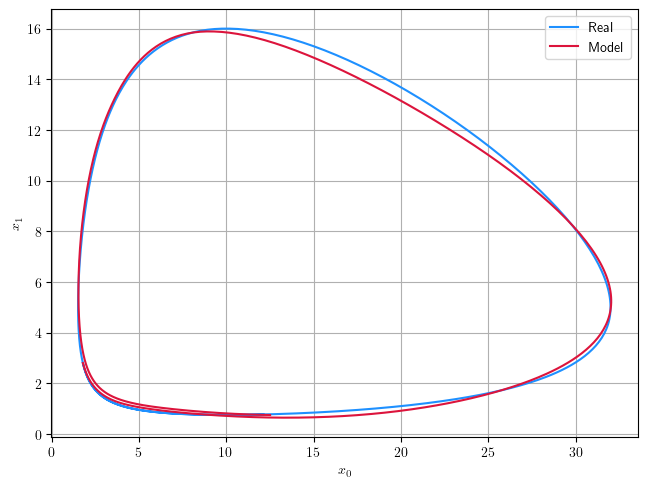

In [261]:
evaluation_plot()